In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Wine Classification System (Wine Dataset)

Using k_nearest Neighbors (k-NN) with PCA, crate a classification model to identify wine varieties from their measurable attributes.

## Load and Prepare Dataset

In [2]:
wine_df = pd.read_csv('wine_data.csv')

print(wine_df.info())
wine_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
wine_df['target'].value_counts(normalize=True)

1    0.398876
0    0.331461
2    0.269663
Name: target, dtype: float64

In [5]:
# Prepare features (X) and target (y)
wine_X = wine_df.drop('target', axis=1)
wine_y = wine_df['target']

# Standardize the data
scaler = StandardScaler()
wine_X_scaled = scaler.fit_transform(wine_X)

wine_df.shape, wine_X_scaled.shape

((178, 14), (178, 13))

## k-Nearest Neighbors (k-NN) Classification

In [6]:
# Initialize PCA
wine_pca = PCA()

# Fit PCA model to scaled data
wine_pca.fit(wine_X_scaled)

# Get explained variance ratio
wine_explained_variance_ratio = wine_pca.explained_variance_ratio_

# Tranform the standardized data to get prinicpal components
wine_X_pca = wine_pca.transform(wine_X_scaled)

# Create DataFrame with principal components
wine_pca_df = pd.DataFrame(
    data = wine_X_pca,
    columns=[f'PC{i+1}' for i in range (wine_X_pca.shape[1])]
)
wine_pca_df['target'] = wine_df['target']
wine_cumulative_variance = np.cumsum(wine_explained_variance_ratio)

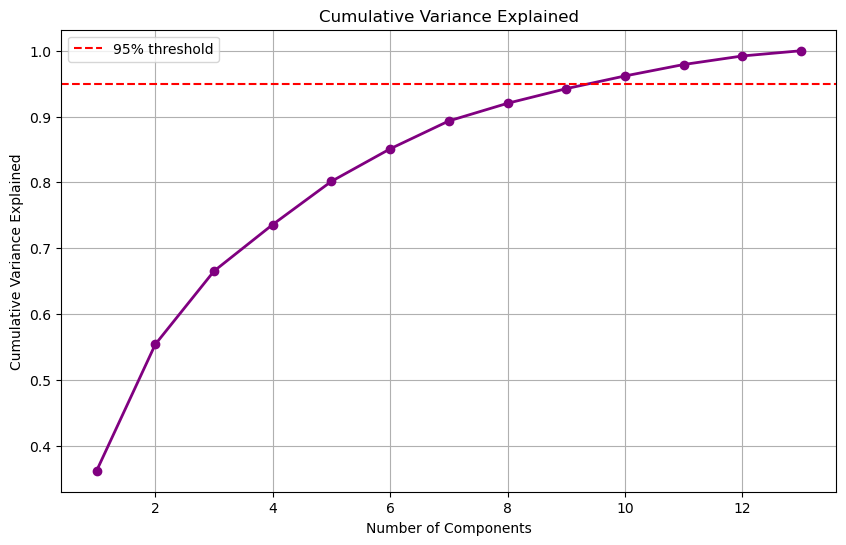

Components needed for 95% variance: 10


In [7]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(wine_cumulative_variance)+1), wine_cumulative_variance, 'o-',
         linewidth='2', color='purple')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

wine_n_components_variance = np.argmax(wine_cumulative_variance >= 0.95) + 1
print(f"Components needed for 95% variance: {wine_n_components_variance}")

In [8]:
wine_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,target
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,-0.223880,0.596427,0.065139,0.641443,1.020956,-0.451563,0.540810,-0.066239,0
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,-0.927120,0.053776,1.024416,-0.308847,0.159701,-0.142657,0.388238,0.003637,0
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,0.549276,0.424205,-0.344216,-1.177834,0.113361,-0.286673,0.000584,0.021717,0
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,0.114431,-0.383337,0.643593,0.052544,0.239413,0.759584,-0.242020,-0.369484,0
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,-0.406520,0.444074,0.416700,0.326819,-0.078366,-0.525945,-0.216664,-0.079364,0


In [9]:
# Prepare features and target for post-PCA data
wine_pca_X = wine_pca_df.drop('target', axis=1)
wine_pca_y = wine_pca_df['target']

# Split the data into training and testing sets (75-25 split)
wine_pca_X_train, wine_pca_X_test, wine_pca_y_train, wine_pca_y_test = train_test_split(wine_pca_X, wine_pca_y, test_size=0.25, random_state=42)

In [10]:
# Covariance matric for Mahalanobis distance
wine_cov = np.cov(wine_pca_X, rowvar=False)

# Parameters to test
wine_param_grid = {
    'n_neighbors': list(range(1, 11, 2)), #There are 10 components, we check odd values from 1-9
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create KNN model
wine_knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
wine_grid_search = GridSearchCV(wine_knn, wine_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
wine_grid_search.fit(wine_pca_X_train, wine_pca_y_train)

# Get best parameters and score
standard_best_params = wine_grid_search.best_params_
standard_best_score = wine_grid_search.best_score_
print(f"Best parameters (standard metrics): {standard_best_params}")
print(f"Best cross-validation accuracy: {standard_best_score:.4f}")

# Mahalanobis check
# Custom KNN model
wine_knn_mahalanobis = KNeighborsClassifier(metric='mahalanobis', metric_params={'V': wine_cov})

# Param grid
wine_param_grid_mahalanobis = {
   'n_neighbors': list(range(1, 11, 2)),
   'weights': ['uniform', 'distance'],
   'algorithm': ['auto']
}

# Perform grid search for Mahalanobis
print("\nStarting grid search for Mahalanobis metric...")
grid_search_mahalanobis = GridSearchCV(wine_knn_mahalanobis, wine_param_grid_mahalanobis, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_mahalanobis.fit(wine_pca_X_train, wine_pca_y_train)

# Get best parameters and score
mahalanobis_best_params = grid_search_mahalanobis.best_params_
mahalanobis_best_score = grid_search_mahalanobis.best_score_
print(f"Best parameters (Mahalanobis): {mahalanobis_best_params}")
print(f"Best cross-validation accuracy: {mahalanobis_best_score:.4f}")

# Determine overall best model
best_scores = {
    'Standard': (standard_best_score, standard_best_params),
    'Mahalanobis': (mahalanobis_best_score, mahalanobis_best_params)
}

best_model_type = max(best_scores, key=lambda k: best_scores[k][0])
best_score = best_scores[best_model_type][0]
best_params = best_scores[best_model_type][1]

print(f"\nOverall best model: {best_model_type}")
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

Starting grid search for standard metrics...


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9479

Starting grid search for Mahalanobis metric...
Best parameters (Mahalanobis): {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation accuracy: 0.9325

Overall best model: Standard
Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9479


Test set accuracy: 0.9556

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.89      0.94        18
           2       0.92      1.00      0.96        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



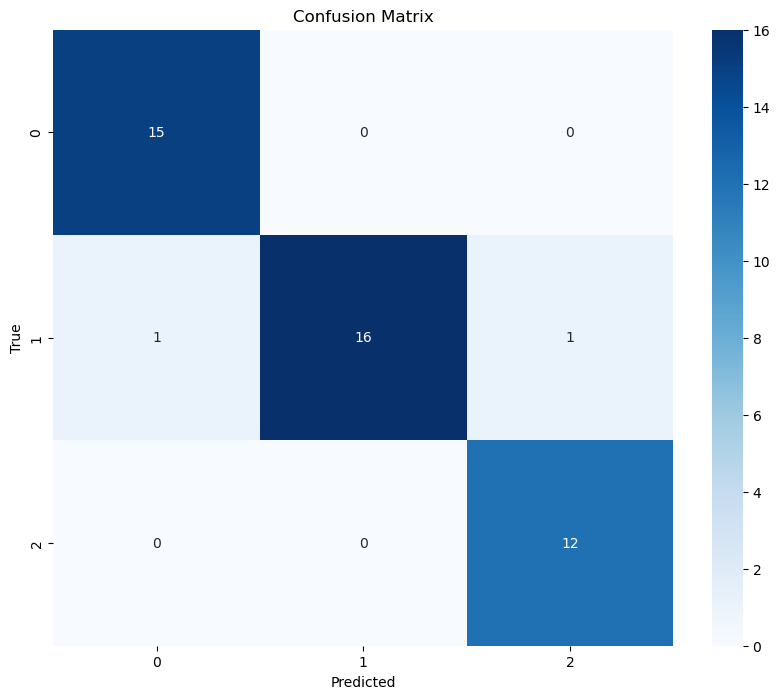

In [11]:
# Final model with best parameters
wine_final_model = wine_grid_search.best_estimator_

# Make predictions on test set
wine_y_pred = wine_final_model.predict(wine_pca_X_test)

# Check accuracy
wine_test_accuracy = accuracy_score(wine_pca_y_test, wine_y_pred)

# Create confusion matric
wine_cm = confusion_matrix(wine_pca_y_test, wine_y_pred)

# Run this cell without changes
print(f"Test set accuracy: {wine_test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(wine_pca_y_test, wine_y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(wine_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Chickwts Recommendation System

Using the chicken weights dataset as a proxy, build a recommendation system that leverages PCA and similarity metrics to suggest comparable feed products that might produce similar results.

## Load and Prepare the Dataset

In [12]:
chw_df = pd.read_csv('chickwts_data.csv')

print(chw_df.info())
chw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   feed_name            100 non-null    object 
 1   proteinContent       100 non-null    float64
 2   fatContent           100 non-null    float64
 3   fiberContent         100 non-null    float64
 4   calciumContent       100 non-null    float64
 5   phosphorusContent    100 non-null    float64
 6   moistureContent      100 non-null    float64
 7   ashContent           100 non-null    float64
 8   metabolizableEnergy  100 non-null    int64  
 9   lysineContent        100 non-null    float64
 10  methionineContent    100 non-null    float64
 11  particleSize         100 non-null    float64
 12  density              100 non-null    float64
 13  price                100 non-null    float64
 14  shelfLife            100 non-null    int64  
 15  weight               100 non-null    floa

,feed_name,proteinContent,fatContent,fiberContent,calciumContent,phosphorusContent,moistureContent,ashContent,metabolizableEnergy,lysineContent,methionineContent,particleSize,density,price,shelfLife,weight
0,FirstPeck,19.5,3.2,2.4,0.82,0.78,10.8,4.5,2921,0.96,0.43,3.5,0.57,1.71,295,16.285714
1,ChickStart Plus,18.2,3.8,3.9,3.02,0.68,9.3,6.9,2865,0.99,0.37,3.4,0.70,1.67,302,20.588235
2,EarlyGrow Formula,19.3,4.6,3.2,1.20,0.69,10.2,5.8,2950,1.05,0.38,3.3,0.69,1.65,331,20.909091
3,HatchMate Premier,20.2,3.7,3.8,3.16,0.63,11.4,5.7,2866,1.11,0.38,3.2,0.74,1.71,292,23.125000
4,PeepNourish,19.2,3.9,4.2,3.06,0.61,9.3,5.9,2860,0.91,0.34,2.9,0.64,1.67,309,22.068966


In [13]:
len(chw_df['feed_name'].unique())

100

In [14]:
num_chw = chw_df.drop('feed_name', axis=1)

# Standardize the data
scaler = StandardScaler()
chw_df_scaled = scaler.fit_transform(num_chw)

chw_df.shape, chw_df_scaled.shape

((100, 16), (100, 15))

## Recommendation System

In [15]:
# Initialize PCA
chw_pca = PCA()

# Fit PCA model to scaled data
chw_pca.fit(chw_df_scaled)

# Get explained variance ratio
chw_explained_variance_ratio = chw_pca.explained_variance_ratio_

# Tranform the standardized data to get principal components
chw_X_pca = chw_pca.transform(chw_df_scaled)

# Create DataFrame with principal components
chw_pca_df = pd.DataFrame(
    data = chw_X_pca,
    columns = [f'PC{i+1}' for i in range (chw_X_pca.shape[1])]
)
chw_pca_df['feed_name'] = chw_df['feed_name']

In [16]:
chw_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,feed_name
0,2.165341,-1.662877,-2.001974,0.287358,1.295925,-2.129853,-1.021869,-0.044351,0.172055,0.291492,0.440832,0.647726,0.311861,-0.538961,0.323550,FirstPeck
1,-0.437253,-2.154582,0.447715,-0.898401,-0.563422,0.759027,-1.072722,-1.374545,-1.014007,0.237171,-0.337924,0.333565,0.117440,-0.198200,0.094137,ChickStart Plus
2,1.194280,-1.615269,1.185500,0.028282,0.295071,0.416842,0.467878,0.607307,-0.004217,0.134765,-0.481279,-0.934107,0.433634,0.030678,0.168912,EarlyGrow Formula
3,0.247816,-1.225305,-1.485480,-2.520275,0.587439,1.017166,0.148764,-0.792902,-0.303972,-0.279604,-1.038816,0.454317,-0.064684,-0.183927,-0.054973,HatchMate Premier
4,-0.956156,-1.177873,0.449352,-0.123604,-0.678188,-0.321288,0.061722,-1.514429,-0.376512,-0.103643,-0.304447,0.394461,-0.606592,0.222464,0.050270,PeepNourish


In [39]:
chw_prep_df = chw_pca_df[['feed_name', 'PC1']].set_index('feed_name')

# Calculate cosine similarity
chw_cosine_sim_matrix = cosine_similarity(chw_prep_df)
chw_cosine_dist_matrix = 1 - chw_cosine_sim_matrix

feed_list = chw_pca_df['feed_name'].tolist()
chw_cosine_df = pd.DataFrame(chw_cosine_dist_matrix, index=feed_list, columns=feed_list)

In [40]:
def recommend_feed(feed_brand, dis_matrix, feed_list, n=2):
    """Recommend n similar feed brands given feed brand"""
    # Find index of brand
    try:
        feed_idx = feed_list.index(feed_brand)
    except ValueError:
        return "Feed brand not found"

    # Get distances for specified brand
    distances = dis_matrix[feed_idx].copy()

    # Set distance of self to infinity so it is not selected
    distances[feed_idx] = float('inf')

    # Get indixes of similar brands
    most_similar_idx = np.argsort(distances)[:n]

    # Return brands
    recommendations = [f"{feed_list[idx]} (distance: {distances[idx]:.4f})" 
                      for idx in most_similar_idx]
    return recommendations

In [42]:
test_brands = ['PulletFirst Complete', 'NestResult Formula', 'MarketPrep Formula']

print("\nFeed Recommendations:")
for feed in test_brands:
    print(f"\nFor '{feed}':")
    print("  " + "\n  ".join(recommend_feed(feed, chw_cosine_dist_matrix, feed_list)))


Feed Recommendations:

For 'PulletFirst Complete':
  MeatMax Complete (distance: 0.0000)
  GrowthFinish Advanced (distance: 0.0000)

For 'NestResult Formula':
  MeatMax Complete (distance: 0.0000)
  MatureBlend Complete (distance: 0.0000)

For 'MarketPrep Formula':
  FirstPeck (distance: 0.0000)
  ShellStrength Pro (distance: 0.0000)


# US Arrests Natural Groupings

Apply clustering techniques (both K-Means and Gaussian Mixture Models) to discover natural groupings in crime data, using feature selection and dimensionality reduction to focus on the most relevant patterns.

## Load and Prepare Dataset

In [3]:
arrests_df = pd.read_csv('arrests_data.csv')

print(arrests_df.info())
arrests_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None


,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [44]:
arrests_df.columns

Index(['Unnamed: 0', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

In [45]:
arrests_df['Unnamed: 0'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [4]:
arrests_df = arrests_df.rename({'Unnamed: 0': 'State'}, axis=1)

In [47]:
arrests_df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [5]:
num_arrests = arrests_df.drop('State', axis=1)

# Standardize the dara
scaler = StandardScaler()
arrests_df_scaled = scaler.fit_transform(num_arrests)

arrests_df.shape, arrests_df_scaled.shape

((50, 5), (50, 4))

## Clustering (K-Means & GMM)

Text(0.5, 1.0, 'Elbow Method for K-Means')

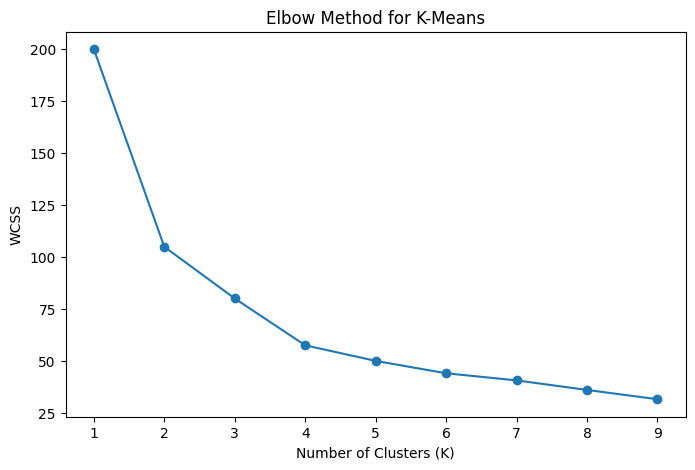

In [6]:
# Calculate WCSS for k-means
wcss = []
k_values = range(1,10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(arrests_df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for K-Means")

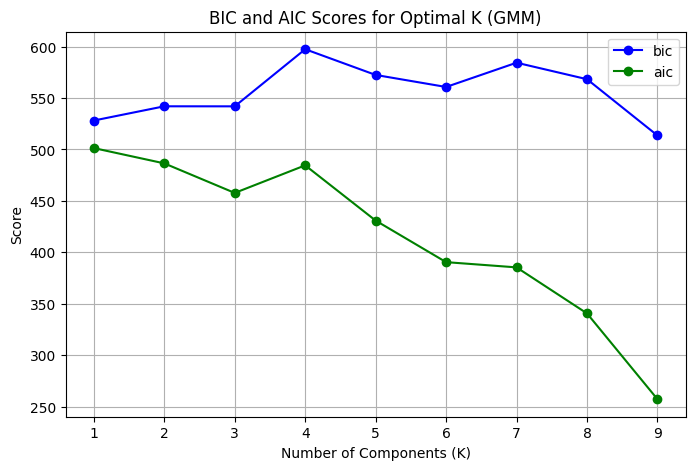

In [7]:
# Calculate AIC and BIC for GMM

bic_scores = []
aic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(arrests_df_scaled)
    bic_scores.append(gmm.bic(arrests_df_scaled))
    aic_scores.append(gmm.aic(arrests_df_scaled))

# Plot AIC and BIC
plt.figure(figsize=(8,5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-', color='blue', label='bic')
plt.plot(k_values, aic_scores, marker='o', linestyle='-', color='green', label='aic')
plt.xlabel("Number of Components (K)")
plt.ylabel("Score")
plt.legend()
plt.title("BIC and AIC Scores for Optimal K (GMM)")
plt.grid(True)
plt.show()

In [8]:
# K-Means
optimal_k = 2 # Based on Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(arrests_df_scaled)
arrests_df['KMeans_Cluster'] = kmeans.fit_predict(arrests_df_scaled)

# GMM
optimal_k_bic = 9
gmm = GaussianMixture(n_components=optimal_k_bic, random_state=42, n_init=10)
gmm.fit(arrests_df_scaled)
arrests_df["GMM_Cluster"] = gmm.predict(arrests_df_scaled)
arrests_df["GMM_Probability"] = gmm.predict_proba(arrests_df_scaled).max(axis=1)

# Silhouette Scores
silhouette_kmeans = silhouette_score(arrests_df_scaled, arrests_df['KMeans_Cluster'])
silhouette_gmm = silhouette_score(arrests_df_scaled, arrests_df['GMM_Cluster'])

round(silhouette_kmeans, 4), round(silhouette_gmm, 4)

(np.float64(0.4085), np.float64(0.1923))

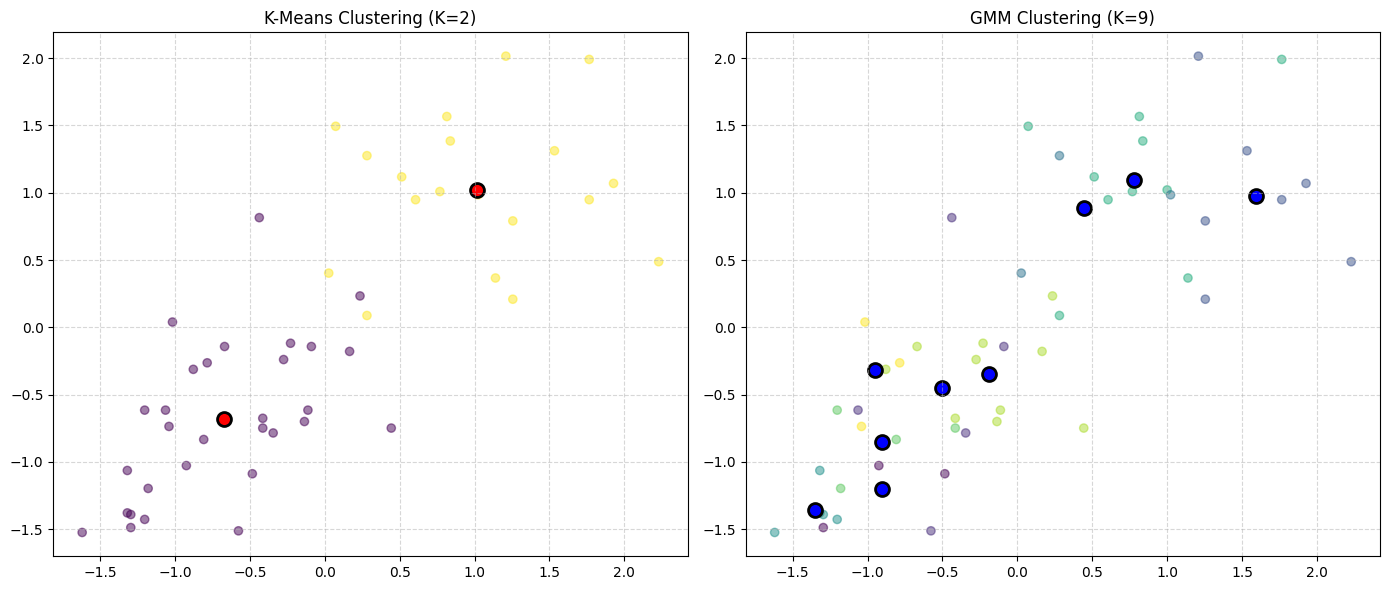

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# K-Means Clustering Plot
axes[0].scatter(arrests_df_scaled[:, 0], arrests_df_scaled[:, 1], c=arrests_df['KMeans_Cluster'], cmap='viridis', alpha=0.5)
axes[0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=100, c='red', marker='o', edgecolor='k', linewidth=2, label='Cluster Centers')
axes[0].set_title('K-Means Clustering (K=2)')
axes[0].grid(True, linestyle='--', alpha=0.5)

# GMM Clustering Plot
axes[1].scatter(arrests_df_scaled[:, 0], arrests_df_scaled[:, 1], c=arrests_df['GMM_Cluster'], cmap='viridis', alpha=0.5)
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                s=100, c='blue', marker='o', edgecolor='k', linewidth=2, label='Cluster Centers')
axes[1].set_title('GMM Clustering (K=9)')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()